In [50]:
import torch 
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Linear
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split #delete
from torchvision.transforms import Lambda
import numpy as np
from torchview import draw_graph
from torchinfo import summary
import pandas as pd
import matplotlib.pyplot as plt
import hiddenlayer as hl
from timeit import default_timer as timer
import warnings

print("You are using:")
!python --version
print(f"{torch.__version__=}")
print("MPS support=", torch.backends.mps.is_available())
if torch.backends.mps.is_available():
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

# Set seed for reproducibility
torch.manual_seed(43)
rng = np.random.default_rng(seed=4242)


You are using:
Python 3.13.1
torch.__version__='2.6.0'
MPS support= True
Using device: mps


In [48]:
import os 
import glob 
from PIL import Image

dataset_dir = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/images"

img_paths = glob.glob(os.path.join(dataset_dir, "*", "*.jpg"))
attribute4image_path = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/attributes/image_attribute_labels.txt"
attributes_path = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/attributes/attributes.txt"
class_path = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/classes.txt"
labels4image_path = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/image_class_labels.txt"
images_names = '/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/images.txt'

labels4image = pd.read_csv(labels4image_path, sep=' ', header=None)
classnames = pd.read_csv(class_path, sep=' ', header=None)

images_dict = {} #dictionary with image name and id

with open(images_names, 'r') as f:
    for line in f:
        img_ID, img_foldername = line.strip().split()
        img_name = img_foldername.split('/')[1]
        images_dict[img_name] = int(img_ID)
   

In [63]:
#modify imagefolder to include the IDs

class ImageFolderWithIDs(ImageFolder):
    def __init__(self, root, transform=None, id_map=None):
        super().__init__(root, transform)
        self.id_map = id_map

    def __getitem__(self, index):

        img, label = super().__getitem__(index)

        img_path, _ = self.samples[index]
        img_filename = os.path.basename(img_path)

        image_id = self.id_map[img_filename]
        label += 1

        return img, label, image_id
       

Image shape: torch.Size([3, 224, 224]), label: 62, img_id: 3590


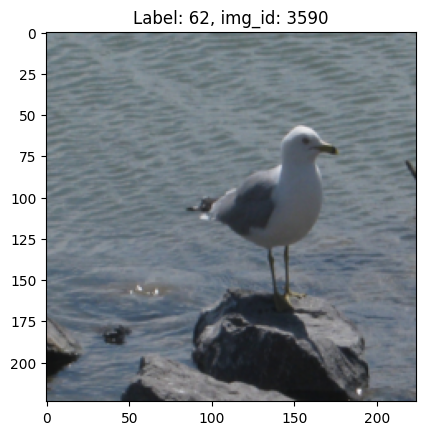

In [140]:
#load the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)), #resize to 224x224, ResNet input size
    transforms.ToTensor()
])

dataset = ImageFolderWithIDs(dataset_dir, transform=transform, id_map=images_dict)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for img, label, img_id in dataloader:
    print(f"Image shape: {img[0].shape}, label: {label[0]}, img_id: {img_id[0]}")

    image = img[0].numpy().transpose(1, 2, 0)
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.title(f"Label: {label[0]}, img_id: {img_id[0]}")
    plt.show()
    break

In [77]:
classes = sorted(np.unique(dataset.targets))
print(f"Number of Classes: {len(classes)}")
print(f"Dataset shape before splitting: {len(dataset)}")

Number of Classes: 200
Dataset shape before splitting: 11788


In [ ]:
#Check if the dataset is balanced
label_count = {}

for _, label, img_id in dataset:
    if label not in label_count:
        label_count[label] = 0
    label_count[label] += 1

label_count

In [90]:
train_data, test_data, val_data = random_split(dataset, [0.75, 0.2, 0.05] )
print(f"Dataset shape after splitting: training={len(train_data)}, testing={len(test_data)}, validation={len(val_data)}")

Dataset shape after splitting: training=8842, testing=2357, validation=589


In [133]:
#load the attributes
attributes = torch.zeros(len(dataset), 312)

with open (attribute4image_path, 'r') as f:
    for line in f:
        value = line.strip().split()
        img_ID, att_ID, is_present = value[:3]
        attributes[int(img_ID)-1, int(att_ID)-1] = int(is_present)



In [142]:
train_data.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomCrop(224, 224)
])

In [93]:
#Create the dataloaders for each of them, batch size is set
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [143]:
for img, label, img_id in train_loader:
    print(f"Image shape: {img.shape[0]}, label: {label[0]}, img_id: {img_id[0]}")

    #image = img[0].numpy().transpose(1, 2, 0)
    #image = np.clip(image, 0, 1)

    #plt.imshow(image)
    #plt.title(f"Label: {label[0]}, img_id: {img_id[0]}")
    #plt.show()
    break

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [105]:
from torchvision.models import resnet50, ResNet50_Weights

In [107]:
RESNET = resnet50(pretrained=True)
#model_graph = draw_graph(RESNET101, (torch.randn(1, 3, 224, 224)), device=device, expand_nested=True)
#model_graph.visual_graph
summary(RESNET, (32, 3, 224, 224), device=device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/niccolozenaro/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [02:01<00:00, 842kB/s] 


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [120]:
#fine-tuning the model

class ResNet50AttributesTuned(nn.Module):
    def __init__(self, num_attributes, pretrained=True, freeze_backbone=True):
        super(ResNet50AttributesTuned, self).__init__()

        self.resnet = resnet50(pretrained=pretrained)

    #finetune only the last layer 
        if freeze_backbone:
            for name, param in self.resnet.parameters():
                if "layer4" or "fc" in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_attributes)

    def forward(self, x):
        return torch.sigmoid(self.resnet(x))        